In [1]:
import torch
import torch.nn as nn

from torch.utils.data import DataLoader
from torchvision import datasets, transforms


In [2]:
# CIFAR-10 mean and standard deviation
CIFAR_MEAN = [0.4914, 0.4822, 0.4465]
CIFAR_STD = [0.2023, 0.1994, 0.2010]

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(0.1, 0.1, 0.1, 0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=CIFAR_MEAN, std=CIFAR_STD),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=CIFAR_MEAN, std=CIFAR_STD),
])

# Load datasets
raw_train_dataset = datasets.CIFAR10(root='data/CIFAR10', train=True, download=True, transform=train_transform)
test_dataset = datasets.CIFAR10(root='data/CIFAR10', train=False, download=True, transform=test_transform)
train_dataset, val_dataset = torch.utils.data.random_split(raw_train_dataset, [0.9, 0.1])

print(f"{len(train_dataset)} samples in CIFAR10 train dataset")
print(f"{len(val_dataset)} samples in CIFAR10 validation dataset")
print(f"{len(test_dataset)} samples in CIFAR10 test dataset")

45000 samples in CIFAR10 train dataset
5000 samples in CIFAR10 validation dataset
10000 samples in CIFAR10 test dataset


In [3]:
BATCH_SIZE = 128
NUM_OF_WORKERS = 2

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_OF_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_OF_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_OF_WORKERS)

print(f"{len(train_loader)} batches in train dataset")
print(f"{len(val_loader)} batches in validation dataset")
print(f"{len(test_dataset)} batches in test dataset")

352 batches in train dataset
40 batches in validation dataset
10000 batches in test dataset


In [4]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
        )

        self.relu = nn.ReLU()

        self.conv3 = nn.Conv2d(in_channels, out_channels, kernel_size=1,
                               stride=1) if in_channels != out_channels else None

    def forward(self, x):
        out = self.block(x)
        if self.conv3 is not None:
            x = self.conv3(x)
        out += x
        out = self.relu(out)

        return out

In [5]:
class ResNetModel(nn.Module):
    def __init__(self, num_classes=10, num_blocks=6):
        super().__init__()

        self.initial_block = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
        )

        self.hidden_blocks = nn.Sequential(
            ResidualBlock(32, 64),
            ResidualBlock(64, 32),
            nn.MaxPool2d(2),
            ResidualBlock(32, 16),
            nn.MaxPool2d(2),
        )

        self.flatten = nn.Flatten(start_dim=1)

        # Classification head
        self.classification_head = nn.Sequential(
            # num_channels, height, width
            nn.Linear(16 * 8 * 8, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes),
        )

    def forward(self, x, verbose=False):
        if verbose:
            print(f"{x.shape=}")
        x = self.initial_block(x)
        if verbose:
            print(f"{x.shape=}")
        x = self.hidden_blocks(x)
        if verbose:
            print(f"{x.shape=}")
        x = self.flatten(x)
        if verbose:
            print(f"{x.shape=}")
        x = self.classification_head(x)
        if verbose:
            print(f"{x.shape=}")
        return x

In [6]:
# Test model's functionality with dummy data point
model = ResNetModel(num_classes=10)

dummy_dp = torch.randn(10, 3, 32, 32)
dummy_output = model.forward(dummy_dp)

print(f"Dummy output logits shape: {dummy_output.shape}")

Dummy output logits shape: torch.Size([10, 10])


In [7]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
from tqdm import tqdm


def train_epoch(model, train_loader, criterion, optimizer):
    model.train()

    running_loss = 0.0
    correct = 0
    total_predictions = 0

    pbar = tqdm(train_loader, desc="Training")
    for inputs, targets in pbar:
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item()
        _, predicted_class = outputs.max(1)
        total_predictions += targets.size(0)
        correct += predicted_class.eq(targets).sum().item()

        # Update progress bar
        pbar.set_postfix({
            'loss': running_loss / (pbar.n + 1),
            'accuracy': 100.0 * correct / total_predictions
        })

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100.0 * correct / total_predictions

    return epoch_loss, epoch_accuracy

In [9]:
def validate(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total_predictions = 0

    with torch.no_grad():
        for inputs, targets in tqdm(val_loader, desc='Validating'):
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            running_loss += loss.item()
            _, predicted_class = outputs.max(1)
            total_predictions += targets.size(0)
            correct += predicted_class.eq(targets).sum().item()

    epoch_loss = running_loss / len(val_loader)
    epoch_accuracy = 100.0 * correct / total_predictions

    return epoch_loss, epoch_accuracy

In [10]:
def test(model, test_loader):
    model.eval()
    correct = 0
    total_predictions = 0
    class_correct = [0] * 10
    class_total_predictions = [0] * 10

    classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

    with torch.no_grad():
        for inputs, targets in tqdm(test_loader, desc='Testing'):
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

            outputs = model(inputs)
            _, predicted_class = outputs.max(1)

            total_predictions += targets.size(0)
            correct += predicted_class.eq(targets).sum().item()

            # Per-class accuracy
            for i in range(targets.size(0)):
                target = targets[i]
                class_correct[target] += (predicted_class[i] == target)
                class_total_predictions[target] += 1

    overall_acc = 100.0 * correct / total_predictions
    print(f"Overall accuracy: {overall_acc:.2f}%")
    print(f"Per class accuracy:")
    for i in range(10):
        acc = 100.0 * class_correct[i] / class_total_predictions[i]
        print(f"{classes[i]:>10s}: {acc:.2f}%")

    return overall_acc

In [11]:
import matplotlib.pyplot as plt

NUM_EPOCHS = 50
LEARNING_RATE = 0.003

model = model.to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

stats = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
}

best_val_acc = 0.0

print("Starting training...")
for epoch in range(NUM_EPOCHS):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)
    val_loss, val_acc = validate(model, val_loader, criterion)

    stats['train_loss'].append(train_loss)
    stats['train_acc'].append(train_acc)
    stats['val_loss'].append(val_loss)
    stats['val_acc'].append(val_acc)

    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch + 1}/{NUM_EPOCHS}")
        print(f"Train loss: {train_loss:.4f}, Train accuracy: {train_acc:.2f}%")
        print(f"Validation loss: {val_loss:.4f}, Validation accuracy: {val_acc:.2f}%")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_resnet_cifar10.pth")
        # print(f"Model saved with best validation accuracy: {best_val_acc:.2f}%")

Starting training...


Validating: 100%|██████████| 40/40 [00:06<00:00,  6.01it/s]


Epoch 5/50
Train loss: 1.2046, Train accuracy: 56.41%
Validation loss: 1.1917, Validation accuracy: 56.94%


Validating: 100%|██████████| 40/40 [00:06<00:00,  6.00it/s]


Epoch 10/50
Train loss: 1.0396, Train accuracy: 62.70%
Validation loss: 1.0220, Validation accuracy: 63.60%


Validating: 100%|██████████| 40/40 [00:06<00:00,  6.12it/s]


Epoch 15/50
Train loss: 0.9458, Train accuracy: 66.45%
Validation loss: 0.9384, Validation accuracy: 65.72%


Validating: 100%|██████████| 40/40 [00:06<00:00,  6.16it/s]


Epoch 20/50
Train loss: 0.8739, Train accuracy: 69.01%
Validation loss: 0.9457, Validation accuracy: 67.02%


Validating: 100%|██████████| 40/40 [00:06<00:00,  6.29it/s]


Epoch 25/50
Train loss: 0.8388, Train accuracy: 70.29%
Validation loss: 0.8761, Validation accuracy: 68.42%


Validating: 100%|██████████| 40/40 [00:06<00:00,  6.13it/s]


Epoch 30/50
Train loss: 0.8052, Train accuracy: 71.65%
Validation loss: 0.8458, Validation accuracy: 70.76%


Validating: 100%|██████████| 40/40 [00:06<00:00,  6.10it/s]


Epoch 35/50
Train loss: 0.7773, Train accuracy: 72.40%
Validation loss: 0.9223, Validation accuracy: 68.72%


Validating: 100%|██████████| 40/40 [00:06<00:00,  6.23it/s]


Epoch 40/50
Train loss: 0.7631, Train accuracy: 73.06%
Validation loss: 0.8065, Validation accuracy: 71.74%


Validating: 100%|██████████| 40/40 [00:06<00:00,  6.21it/s]


Epoch 45/50
Train loss: 0.7378, Train accuracy: 73.66%
Validation loss: 0.7891, Validation accuracy: 72.58%


Validating: 100%|██████████| 40/40 [00:06<00:00,  6.17it/s]

Epoch 50/50
Train loss: 0.7212, Train accuracy: 74.44%
Validation loss: 0.7988, Validation accuracy: 72.26%


Loading best model for testing...
Best validation accuracy: 73.24%


Testing: 100%|██████████| 79/79 [00:05<00:00, 13.65it/s]


Overall accuracy: 75.58%
Per class accuracy:
     plane: 76.70%
       car: 91.30%
      bird: 68.00%
       cat: 44.20%
      deer: 73.80%
       dog: 68.00%
      frog: 87.20%
     horse: 77.60%
      ship: 87.40%
     truck: 81.60%

Training history plot saved as 'training_history.png'


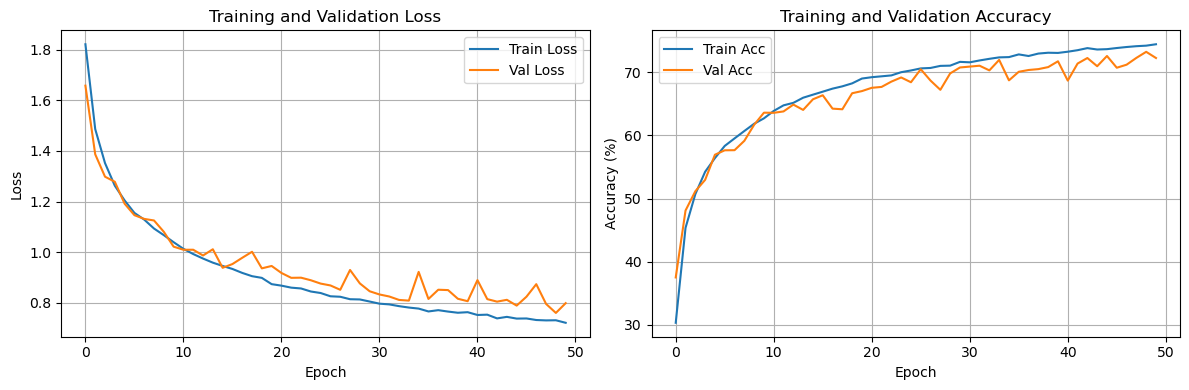

In [12]:
print('=' * 70)
print(f"Loading best model for testing...")
print(f"Best validation accuracy: {best_val_acc:.2f}%")
model.load_state_dict(torch.load('best_resnet_cifar10.pth'))

test_acc = test(model, test_loader)

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(stats['train_loss'], label='Train Loss')
plt.plot(stats['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(stats['train_acc'], label='Train Acc')
plt.plot(stats['val_acc'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.grid(True)

plt.tight_layout()
plt.savefig('training_history.png')
print("\nTraining history plot saved as 'training_history.png'")
